# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [8]:
# Data manipulation
import seaborn as sb
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
from scipy import stats


# GSEA analysis
from collections import defaultdict
import gseapy as gp

# autoML
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import autosklearn.classification
import PipelineProfiler


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier
# xgboost
from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature selection
from sklearn.feature_selection import SelectFdr, f_classif, SelectKBest, SelectFromModel, VarianceThreshold, chi2

# benchmark
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import pickle
# model interpretation
import shap

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
# Set default font size
plt.rcParams['font.size'] = 24
# Set default font size
sb.set(font_scale=.8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [9]:
# load sample id conversion table, drug response data
target_col = "Cetuximab_Standard_3wks_cat"
drug_response_data = pd.read_csv("tables/DrugResponse_LMXfirslevel_trainTest.csv", sep="\t")
# encode target
Y_class_dict={'PD':0,'SD':1, 'OR':1}
# index Y on ircc_short to map to RNAseq ids
Y = drug_response_data[["ircc_id_short", "ircc_id", target_col, "is_test"]].\
	set_index("ircc_id_short")
Y[target_col] = Y[target_col].replace(Y_class_dict)



In [10]:
# parse PROGENy scores for train, test set
progeny_train = pd.read_csv("tables/progenyPath_X_train_T.tsv")
progeny_train.columns = ['ircc_id'] + ['PROGENy_' + c for c in progeny_train.columns[1:].tolist()]
progeny_train = progeny_train.set_index('ircc_id')

progeny_test = pd.read_csv("tables/progenyPath_X_test_T.tsv")
progeny_test.columns = ['ircc_id'] + ['PROGENy_' + c for c in progeny_test.columns[1:].tolist()]
progeny_test = progeny_test.set_index('ircc_id')
progeny_features = list(set(progeny_test.columns.tolist() +  progeny_train.columns.tolist()))

progeny_test.shape
progeny_train.shape


(56, 11)

(172, 11)

In [11]:
# parse train hallmark ssGSEA
f = "data/RNAseq/release_2/ssGSEA_wholeTMM/train_h-scores.tsv"
hallmarks_train = pd.read_csv(f, sep="\t", header=0, index_col=0).T
# index on ircc_short
hallmarks_train.index = [i[:7] for i in hallmarks_train.index.tolist()] 
# join with ircc_long, aggregate RNAseq replicates by mean, , set ircc_id as index
hallmarks_train = pd.merge(hallmarks_train, Y[["ircc_id", target_col]], left_index=True, right_index=True)
hallmarks_train = hallmarks_train.groupby("ircc_id").apply(np.mean).reset_index().set_index('ircc_id')
y_train = hallmarks_train[target_col]
hallmarks_train = hallmarks_train.drop(target_col, axis=1) 

# parse test hallmark ssGSEA
f = "data/RNAseq/release_2/ssGSEA_wholeTMM/test_h-scores.tsv"
hallmarks_test = pd.read_csv(f, sep="\t", header=0, index_col=0).T
# index on ircc_short
hallmarks_test.index = [i[:7] for i in hallmarks_test.index.tolist()] 
# join with ircc_id, aggregate RNAseq replicates by mean, set ircc_id as index
hallmarks_test = pd.merge(hallmarks_test, Y[["ircc_id", target_col]], left_index=True, right_index=True)
hallmarks_test = hallmarks_test.groupby("ircc_id").apply(np.mean).reset_index().set_index('ircc_id')
y_test = hallmarks_test[target_col]
hallmarks_test = hallmarks_test.drop(target_col, axis=1) 

In [12]:
hallmarks_test.shape
hallmarks_train.shape

(56, 50)

(171, 50)

In [13]:
# combine PROGENy, halmarks scores along ircc_id
combined_train = pd.concat([hallmarks_train, progeny_train], axis=1).dropna(how='any')
combined_train.shape
combined_test = pd.concat([hallmarks_test, progeny_test], axis=1).dropna(how='any')
combined_test.shape


(171, 61)

(56, 61)

In [14]:
# scale train, test (0-1) separately
scaler = MinMaxScaler().fit(combined_train)
scaled_combined_train = pd.DataFrame(scaler.transform(combined_train.values),
          columns=combined_train.columns, index=combined_train.index)
scaler = MinMaxScaler().fit(combined_test)              
scaled_combined_test = pd.DataFrame(scaler.transform(combined_test.values),
          columns=combined_test.columns, index=combined_test.index)    
scaled_combined_test.shape
scaled_combined_train.shape
scaled_combined_train.head()


(56, 61)

(171, 61)

,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_DNA_REPAIR,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,HALLMARK_NOTCH_SIGNALING,HALLMARK_ADIPOGENESIS,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_MYOGENESIS,HALLMARK_PROTEIN_SECRETION,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_COMPLEMENT,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_E2F_TARGETS,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V2,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_XENOBIOTIC_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_GLYCOLYSIS,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_UV_RESPONSE_UP,HALLMARK_UV_RESPONSE_DN,HALLMARK_ANGIOGENESIS,HALLMARK_HEME_METABOLISM,HALLMARK_COAGULATION,HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS,PROGENy_EGFR,PROGENy_Hypoxia,PROGENy_JAK.STAT,PROGENy_MAPK,PROGENy_NFkB,PROGENy_PI3K,PROGENy_TGFb,PROGENy_TNFa,PROGENy_Trail,PROGENy_VEGF,PROGENy_p53
ircc_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CRC0014LMX0A02201TUMD02000,0.155338,0.055069,0.060542,0.061771,0.361195,0.145249,0.244081,0.274220,0.129552,0.090855,0.390419,0.000000,0.109600,0.036523,0.087251,0.242017,0.007776,0.276556,0.192988,0.157318,0.363253,0.248805,0.020677,0.000000,0.010822,0.000000,0.186049,0.103772,0.252217,0.203848,0.109771,0.101006,0.089819,0.104429,0.000000,0.171735,0.097548,0.002055,0.236668,0.306091,0.122256,0.119467,0.027479,0.328910,0.105447,0.139760,0.173965,0.063494,0.583205,0.470150,0.060389,0.257592,0.258515,0.098430,0.223898,0.289154,0.168777,0.205129,0.257676,0.847785,0.237590
CRC0019LMX0A02204TUMD05000,0.872865,0.151817,0.555860,0.531107,0.736199,0.816277,0.814410,0.192564,0.305058,0.749720,0.457408,0.417487,0.508089,0.361325,0.639567,0.315738,0.704807,0.818424,0.879081,0.406970,0.220868,0.493335,0.613059,0.222532,0.566388,0.292543,0.156865,0.193308,0.174711,0.158482,0.827156,0.556822,0.643588,0.361068,0.162568,0.516281,0.726912,0.294803,0.784507,0.710355,0.597752,0.433223,0.615927,0.399581,0.429653,0.921239,0.418341,0.735213,0.195441,0.088330,0.491240,0.174084,0.464834,0.533192,0.471634,0.679199,0.279031,0.314054,0.109554,0.488975,0.668839
CRC0021LMX0B02204TUMD02000,0.885654,0.791557,0.675621,0.748577,0.783562,0.768551,0.833425,0.182609,0.584155,0.682920,0.673595,0.326307,0.469094,0.422880,0.479197,0.862957,0.406674,0.944266,0.952079,0.809001,0.702118,0.844977,0.660981,0.524011,0.506571,0.553911,0.485358,0.400424,0.272424,0.722676,0.760227,0.299782,0.500803,0.441677,0.682158,0.574045,0.509700,0.486863,0.674751,0.891039,0.659400,0.464201,0.761618,0.266418,0.372759,0.751735,0.475505,0.858587,0.542185,0.967320,0.409887,0.752835,0.695431,0.414403,0.409781,0.575584,0.291368,0.282202,0.300799,0.837717,0.231870
CRC0022LMX0A02204TUMD04000,0.631122,0.350477,0.667106,0.485381,0.513742,0.503904,0.620713,0.844087,0.470774,0.583729,0.498156,0.776993,0.630577,0.683131,0.479309,0.528100,0.546299,0.700796,0.604386,0.584331,0.647077,0.629617,0.611252,0.837087,0.714148,0.808913,0.524939,0.732048,0.662626,0.575379,0.544911,0.716079,0.519682,0.767253,0.500740,0.770479,0.740276,0.730560,0.287693,0.270195,0.630628,0.554804,0.540469,0.416208,0.519586,0.631436,0.513488,0.578093,0.271430,0.344633,0.564961,0.190616,0.363118,0.489222,0.234519,0.650920,0.247557,0.191625,0.468126,0.648236,0.297123
CRC0025LMX0B02204TUMD02000,0.439592,0.480165,0.601977,0.573207,0.718786,0.432208,0.610324,0.389779,0.598283

In [15]:
# compute feature corr matrix on train
corr_thrs = .7
corr_train_df = scaled_combined_train.corr().stack().reset_index()
corr_train_df.columns = ['F1', 'F2', 'pcc']
# remove self comparisons, sort
corr_train_df['abs_pcc'] = np.abs(corr_train_df.pcc)
corr_train_df = corr_train_df[corr_train_df.F1 != corr_train_df.F2].\
	sort_values('pcc', ascending=False)

# get all features w/t at least one abs(corr) > corr_thrs
colinear_df = corr_train_df[corr_train_df.abs_pcc > corr_thrs].\
	sort_values('abs_pcc', ascending=False)
colinear_df.shape
colinear_df.head()


(156, 4)

,F1,F2,pcc,abs_pcc
1115,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.961677,0.961677
1055,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.961677,0.961677
514,HALLMARK_G2M_CHECKPOINT,HALLMARK_E2F_TARGETS,0.959707,0.959707
1594,HALLMARK_E2F_TARGETS,HALLMARK_G2M_CHECKPOINT,0.959707,0.959707
3351,PROGENy_NFkB,PROGENy_TNFa,0.939090,0.939090


In [16]:
# compute chi2 vs target for all colinear features
colinear_features = set(colinear_df.F1.tolist() + colinear_df.F2.tolist()) 
len(colinear_features)

chi2_stat, pval = [pd.Series(arr) for arr in chi2(scaled_combined_train[colinear_features], y_train)]
chi2_df = pd.concat([chi2_stat,pval], axis=1)
chi2_df.index = colinear_features 
chi2_df.columns = ['chi2_stat', 'Pval']
chi2_df = chi2_df.sort_values('chi2_stat', ascending=False)
chi2_df.shape
chi2_df.head(25) 

46

(46, 2)

,chi2_stat,Pval
HALLMARK_INFLAMMATORY_RESPONSE,1.755819,0.185147
HALLMARK_INTERFERON_GAMMA_RESPONSE,1.476982,0.224247
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.425900,0.232435
HALLMARK_INTERFERON_ALPHA_RESPONSE,1.331119,0.248606
HALLMARK_KRAS_SIGNALING_UP,1.286575,0.256680
HALLMARK_COMPLEMENT,0.908681,0.340465
HALLMARK_ALLOGRAFT_REJECTION,0.852852,0.355747
PROGENy_JAK.STAT,0.842440,0.358700
HALLMARK_UV_RESPONSE_DN,0.700863,0.402494
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.689156,0.406452


In [17]:
# for each pair of colinear features in descending corr order,
#  keep the one with the highest chi2 stat
features_todrop = []
for F1, F2 in zip(colinear_df.F1.tolist(), colinear_df.F2.tolist()):
	if chi2_df.chi2_stat.loc[F1] > chi2_df.chi2_stat.loc[F2] and F1 not in features_todrop:
		features_todrop.append(F2)
		print((F1, F2))	
	elif chi2_df.chi2_stat.loc[F1] < chi2_df.chi2_stat.loc[F2] and F2 not in features_todrop:
		features_todrop.append(F1)
		print((F2, F1))
len(set(features_todrop))

('HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE')
('HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE')
('HALLMARK_G2M_CHECKPOINT', 'HALLMARK_E2F_TARGETS')
('HALLMARK_G2M_CHECKPOINT', 'HALLMARK_E2F_TARGETS')
('PROGENy_NFkB', 'PROGENy_TNFa')
('PROGENy_NFkB', 'PROGENy_TNFa')
('HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ESTROGEN_RESPONSE_EARLY')
('HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ESTROGEN_RESPONSE_EARLY')
('HALLMARK_MYC_TARGETS_V2', 'HALLMARK_MYC_TARGETS_V1')
('HALLMARK_MYC_TARGETS_V2', 'HALLMARK_MYC_TARGETS_V1')
('HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_ADIPOGENESIS')
('HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_ADIPOGENESIS')
('HALLMARK_PEROXISOME', 'HALLMARK_ADIPOGENESIS')
('HALLMARK_PEROXISOME', 'HALLMARK_ADIPOGENESIS')
('HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_COMPLEMENT')
('HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_COMPLEMENT')
('HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_PROTEIN_SECRETION')
('HALLMARK_ANDROGEN_RESPONS

29

In [18]:
chi2_df.loc[list(set(features_todrop))].sort_values('chi2_stat', ascending=False)

,chi2_stat,Pval
HALLMARK_INTERFERON_GAMMA_RESPONSE,1.476982,0.224247
HALLMARK_INTERFERON_ALPHA_RESPONSE,1.331119,0.248606
HALLMARK_KRAS_SIGNALING_UP,1.286575,0.256680
HALLMARK_COMPLEMENT,0.908681,0.340465
HALLMARK_ALLOGRAFT_REJECTION,0.852852,0.355747
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.666769,0.414180
HALLMARK_MYC_TARGETS_V2,0.666493,0.414277
HALLMARK_IL2_STAT5_SIGNALING,0.528784,0.467118
HALLMARK_TGF_BETA_SIGNALING,0.467734,0.494032
HALLMARK_ANDROGEN_RESPONSE,0.278457,0.597714


In [19]:
# drop selected features from train, test
X_encoded_train = scaled_combined_train.drop(list(set(features_todrop)), axis=1)
X_encoded_test = scaled_combined_test.drop(list(set(features_todrop)), axis=1)
X_encoded_train.shape
X_encoded_test.shape


(171, 32)

(56, 32)

In [21]:
# save stacked model input (non-scaled)
pd.concat([combined_train, combined_test]).\
	drop(list(set(features_todrop)), axis=1).\
	    to_csv('tables/preprocessed_features/exprPath_PROGENy+HALLMARK.tsv',  sep='\t')

In [13]:
y_train.shape
y_test.shape 

(171,)

(56,)

In [14]:
y_test.value_counts()

0.0    31
1.0    25
Name: Cetuximab_Standard_3wks_cat, dtype: int64

In [15]:
lr = LogisticRegression().fit(X_encoded_train, y_train)
svm = LinearSVC().fit(X_encoded_train, y_train)
knc = KNeighborsClassifier().fit(X_encoded_train, y_train)
rfc = RandomForestClassifier().fit(X_encoded_train, y_train)
xgc = XGBClassifier().fit(X_encoded_train, y_train)
[(model, accuracy_score(y_test, model.predict(X_encoded_test))) for model in [lr, svm, knc, rfc, xgc]]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:57:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[(LogisticRegression(), 0.5892857142857143),
 (LinearSVC(), 0.5892857142857143),
 (KNeighborsClassifier(), 0.5892857142857143),
 (RandomForestClassifier(), 0.6607142857142857),
 (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=40, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  0.5357142857142857)]

In [16]:
# pipeline to train a uclassifier on expression ssGSEA scores
pipe_steps = [
    ("VarianceFilter", VarianceThreshold(threshold=0)), # drop features with 0 variance
    ("chi2filterFscore", SelectKBest(chi2)), # univariate filter on chi2 stat
    ('LRC', LogisticRegression(class_weight='balanced'))
]
pipeExpr = Pipeline(pipe_steps)

In [17]:
hyperparameter_grid = {
          'chi2filterFscore__k': [10, 20, 30],
          'LRC__C':  np.linspace(.001, 10, 10, endpoint=True),}
          
# Set up the random search with 4-fold stratified cross validation
skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
grid = GridSearchCV(estimator=pipeExpr, 
                    param_grid=hyperparameter_grid, 
                    scoring="accuracy",
                    n_jobs=-1,
                    cv=skf,
                    refit=True,
                    verbose=2)




In [18]:
# train on gene features alone
grid.fit(X_encoded_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=0.001, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=30; total time=   0.0s

[CV] END ...............LRC__C=0.001, chi2filterFscore__k=30; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ...............LRC__C=0.001, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=0.001, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=30; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=30; total time=   0.0s
[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=30; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=1.1119999999999999, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=2.223, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ...............LRC__C=2.223, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=2.223, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=2.223, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=2.223, chi2filterFscore__k=30; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=3.334, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=3.334, chi2filterFscore__k=10; total time=   0.0s[CV] END ...............LRC__C=3.334, chi2filterFscore__k=10; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1




[CV] END ...............LRC__C=3.334, chi2filterFscore__k=10; total time=   0.0s[CV] END ...............LRC__C=3.334, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1




[CV] END ...............LRC__C=3.334, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=3.334, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=3.334, chi2filterFscore__k=30; total time=   0.0s[CV] END ...............LRC__C=3.334, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=3.334, chi2filterFscore__k=30; total time=   0.0s[CV] END ...............LRC__C=4.445, chi2filterFscore__k=10; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ...............LRC__C=4.445, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=4.445, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=3.334, chi2filterFscore__k=10; total time=   0.0s



Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=4.445, chi2filterFscore__k=10; total time=   0.0s[CV] END ...............LRC__C=3.334, chi2filterFscore__k=30; total time=   0.0s




Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=4.445, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=4.445, chi2filterFscore__k=20; total time=   0.0s[CV] END ...............LRC__C=4.445, chi2filterFscore__k=20; total time=   0.0s

[CV] END ...............LRC__C=4.445, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=4.445, chi2filterFscore__k=30; total time=   0.0s[CV] END ...............LRC__C=4.445, chi2filterFscore__k=30; total time=   0.0s[CV] END ...............LRC__C=4.445, chi2filterFscore__k=30; total time=   0.0s[CV] END ...............LRC__C=5.556, chi2filterFscore__k=10; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=4.445, chi2filterFscore__k=30; total time=   0.0s



Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=10; total time=   0.0s[CV] END ...............LRC__C=5.556, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ...............LRC__C=5.556, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=20; total time=   0.0s

[CV] END ...............LRC__C=5.556, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1



[CV] END ...............LRC__C=5.556, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=5.556, chi2filterFscore__k=30; total time=   0.0s[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=10; total time=   0.0s



Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=10; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=5.556, chi2filterFscore__k=30; total time=   0.0s



Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=20; total time=   0.0s
[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=20; total time=   0.0sFitting 4 folds for each of 30 candidates, totalling 120 fits

[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=20; total time=   0.0s
[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=20; total time=   0.0s
[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=30; total time=   0.0s[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=30; total time=   0.0s

[CV] END ...............LRC__C=8.889, chi2filterFscore__k=30; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=30; total time=   0.0s
[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=30; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=30; total time=   0.0s
[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=30; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=30; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...LRC__C=6.667000000000001, chi2filterFscore__k=30; total time=   0.0s
[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=30; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ................LRC__C=10.0, chi2filterFscore__k=30; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=10; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=10; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=10; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=10; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=10; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ................LRC__C=10.0, chi2filterFscore__k=10; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=20; total time=   0.0s
[CV] END ...............LRC__C=8.889, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ................LRC__C=10.0, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=8.889, chi2filterFscore__k=20; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=20; total time=   0.0s


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=8.889, chi2filterFscore__k=20; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=20; total time=   0.0s
[CV] END ..LRC__C=7.7780000000000005, chi2filterFscore__k=20; total time=   0.0s

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1


[CV] END ...............LRC__C=8.889, chi2filterFscore__k=20; total time=   0.0s
[CV] END ................LRC__C=10.0, chi2filterFscore__k=20; total time=   0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('VarianceFilter',
                                        VarianceThreshold(threshold=0)),
                                       ('chi2filterFscore',
                                        SelectKBest(score_func=<function chi2 at 0x1553f032f040>)),
                                       ('LRC',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'LRC__C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01]),
                         'chi2filterFscore__k': [10, 20, 30]},
             scoring='accuracy', verbose=2)

0.661 +/- 0.04 {'LRC__C': 0.001, 'chi2filterFscore__k': 10}
0.661 +/- 0.03 {'LRC__C': 0.001, 'chi2filterFscore__k': 20}
0.673 +/- 0.03 {'LRC__C': 0.001, 'chi2filterFscore__k': 30}
0.649 +/- 0.02 {'LRC__C': 1.1119999999999999, 'chi2filterFscore__k': 10}
0.690 +/- 0.03 {'LRC__C': 1.1119999999999999, 'chi2filterFscore__k': 20}
0.684 +/- 0.02 {'LRC__C': 1.1119999999999999, 'chi2filterFscore__k': 30}
0.672 +/- 0.02 {'LRC__C': 2.223, 'chi2filterFscore__k': 10}
0.690 +/- 0.01 {'LRC__C': 2.223, 'chi2filterFscore__k': 20}
0.690 +/- 0.02 {'LRC__C': 2.223, 'chi2filterFscore__k': 30}
0.678 +/- 0.02 {'LRC__C': 3.334, 'chi2filterFscore__k': 10}
0.678 +/- 0.01 {'LRC__C': 3.334, 'chi2filterFscore__k': 20}
0.696 +/- 0.02 {'LRC__C': 3.334, 'chi2filterFscore__k': 30}
0.684 +/- 0.02 {'LRC__C': 4.445, 'chi2filterFscore__k': 10}
0.672 +/- 0.01 {'LRC__C': 4.445, 'chi2filterFscore__k': 20}
0.696 +/- 0.03 {'LRC__C': 4.445, 'chi2filterFscore__k': 30}
0.690 +/- 0.02 {'LRC__C': 5.556, 'chi2filterFscore__k': 10}
0

In [19]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy on train: %.2f' % grid.best_score_)
# assess best classifier performance on test set
grid_test_score = grid.best_estimator_.score(X_encoded_test, y_test)
y_pred = grid.best_estimator_.predict(X_encoded_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')

# print classification report on test set
print(classification_report(y_test, y_pred))

Best parameters: {'LRC__C': 10.0, 'chi2filterFscore__k': 30}
Accuracy on train: 0.70
Accuracy on test set: 0.571
              precision    recall  f1-score   support

         0.0       0.59      0.77      0.67        31
         1.0       0.53      0.32      0.40        25

    accuracy                           0.57        56
   macro avg       0.56      0.55      0.53        56
weighted avg       0.56      0.57      0.55        56



In [20]:
y_test_predict_proba = grid.predict_proba(X_encoded_test)
roc_auc_score(y_test, y_test_predict_proba[:, 1])

0.7187096774193549

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

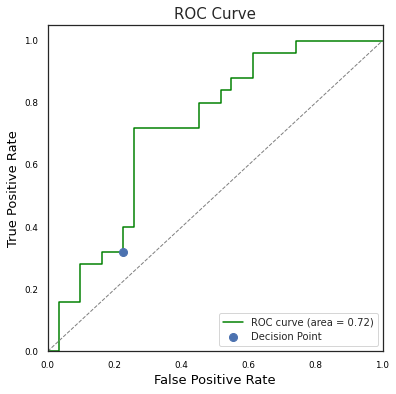

In [21]:
# plot ROC
fp_rates, tp_rates, _ = roc_curve(y_test,y_test_predict_proba[:,1])
roc_auc = auc(fp_rates, tp_rates)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fp_rates, tp_rates, color='green',
            lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')

#plot decision point:
cm =  confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = [i for i in cm.ravel()]
plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('ROC Curve', size=15)
plt.legend(loc="lower right", prop={'size': 10})
plt.subplots_adjust(wspace=.3)

In [22]:
var_selected = grid.best_estimator_[0].get_support()
chi2_selected = grid.best_estimator_[1].get_support()
selected_features = X_encoded_train.columns[var_selected][chi2_selected]
selected_features.shape

(30,)

In [23]:
pd.Series(grid.best_estimator_[-1].coef_[0],
                        name='LogisticRegression_coeff',
                        index=selected_features).\
                            reset_index().sort_values('LogisticRegression_coeff', ascending=False)

,index,LogisticRegression_coeff
16,HALLMARK_UV_RESPONSE_UP,4.817692
25,PROGENy_NFkB,3.415629
15,HALLMARK_P53_PATHWAY,1.414591
8,HALLMARK_APICAL_SURFACE,1.386957
21,HALLMARK_PANCREAS_BETA_CELLS,1.024026
4,HALLMARK_DNA_REPAIR,0.909648
17,HALLMARK_UV_RESPONSE_DN,0.899999
0,HALLMARK_HYPOXIA,0.881158
10,HALLMARK_PI3K_AKT_MTOR_SIGNALING,0.873827
28,PROGENy_VEGF,0.829395


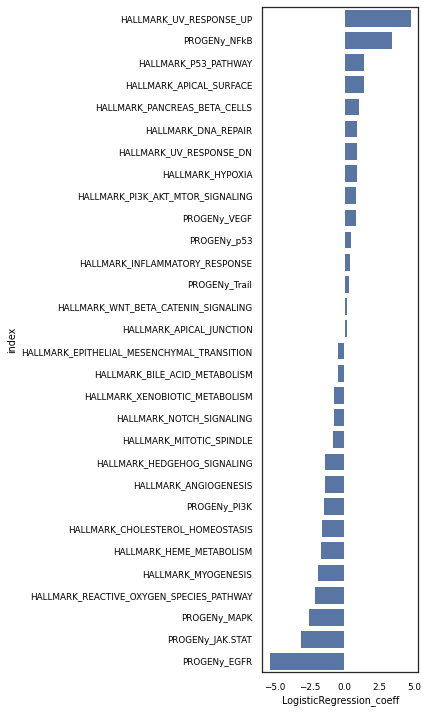

In [24]:
importance = pd.Series(grid.best_estimator_[-1].coef_[0],
                        name='LogisticRegression_coeff',
                        index=selected_features).\
                            reset_index().sort_values('LogisticRegression_coeff', ascending=False)
fig,ax = plt.subplots(figsize=(6,10))
ax = sb.barplot(x="LogisticRegression_coeff",
                y='index',
                    color='b',
                    data=importance,
                    ax=ax)
plt.tight_layout()

In [25]:
pd.Series(grid.best_estimator_[-1].coef_[0],
                        name='LogisticRegression_coeff',
                        index=selected_features).\
                            reset_index().sort_values('LogisticRegression_coeff', ascending=False)

,index,LogisticRegression_coeff
16,HALLMARK_UV_RESPONSE_UP,4.817692
25,PROGENy_NFkB,3.415629
15,HALLMARK_P53_PATHWAY,1.414591
8,HALLMARK_APICAL_SURFACE,1.386957
21,HALLMARK_PANCREAS_BETA_CELLS,1.024026
4,HALLMARK_DNA_REPAIR,0.909648
17,HALLMARK_UV_RESPONSE_DN,0.899999
0,HALLMARK_HYPOXIA,0.881158
10,HALLMARK_PI3K_AKT_MTOR_SIGNALING,0.873827
28,PROGENy_VEGF,0.829395


In [26]:
# build a linear shap explainer (not Explainer Tree) for LogRe classifier on train dataset
# SHAP calculates what the prediction of the model would be without feature i, calculates the prediction of the model with feature i, and then calculates the difference
classifier = grid.best_estimator_[-1]
explainer =  shap.explainers.Linear(classifier,
                                    masker=X_encoded_train[selected_features],
                                    data=X_encoded_train[selected_features],
                                    model_output='raw',
                                    feature_perturbation='interventional',
                                    class_names=["PD", "OR-SD"],
                                    feature_names=selected_features)
train_shap_values = explainer.shap_values(X_encoded_train[selected_features])


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


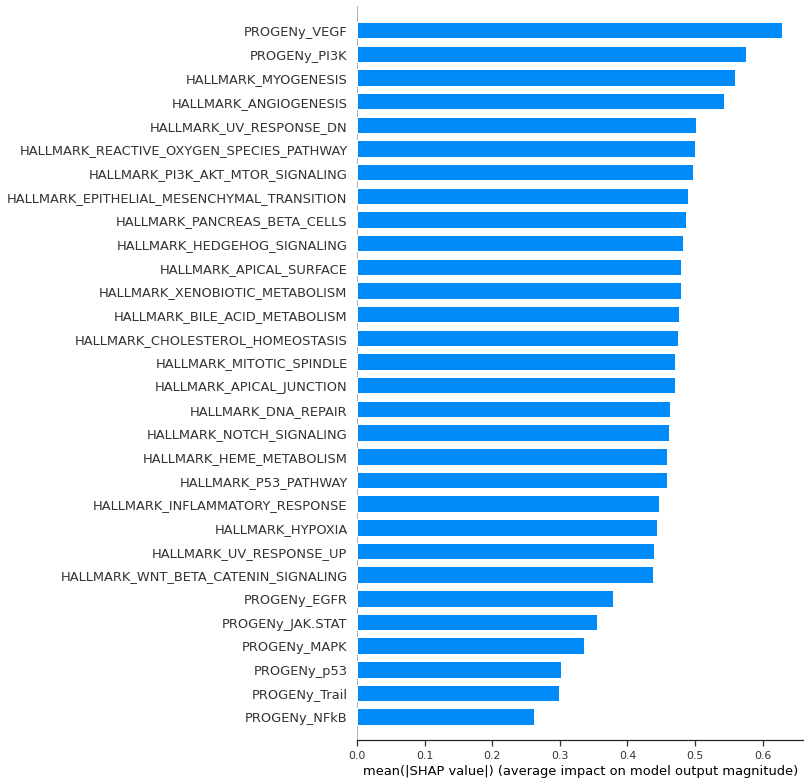

In [27]:
shap.summary_plot(X_encoded_train[selected_features], 
                X_encoded_train[selected_features], 
                feature_names=selected_features,
                show=False, # to save plot to file 
                plot_type="bar",
                max_display=50)

In [28]:
# simplified SHAP summary plot
# from https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy()
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    


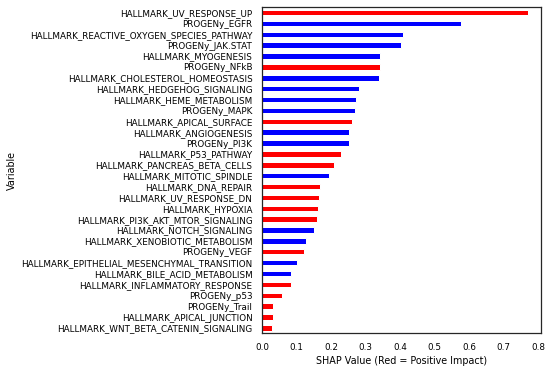

In [29]:
ABS_SHAP(train_shap_values,X_encoded_train[selected_features]) 

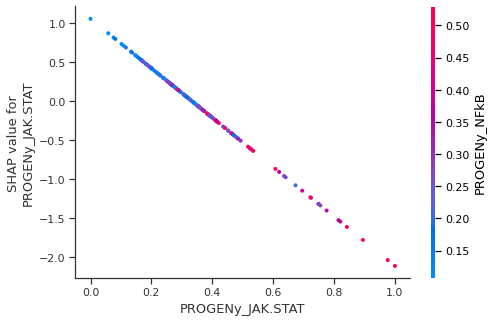

In [30]:
shap.dependence_plot('PROGENy_JAK.STAT', train_shap_values, X_encoded_train[selected_features])

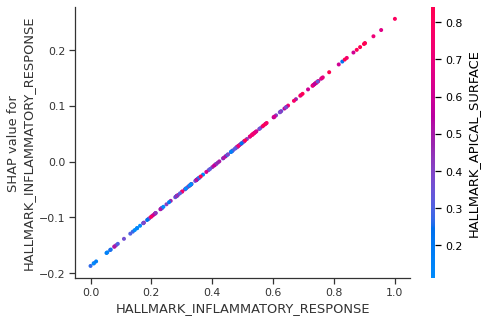

In [31]:
shap.dependence_plot('HALLMARK_INFLAMMATORY_RESPONSE', train_shap_values, X_encoded_train[selected_features])

In [32]:
corr_plot_df = pd.concat([X_encoded_train[selected_features], X_encoded_test[selected_features]])
corr_plot_df = pd.merge(corr_plot_df, Y.set_index('ircc_id')[target_col], left_index=True, right_index=True)
corr_plot_df[target_col] = corr_plot_df[target_col].replace({0:'PD', 1: 'SD-OR'})

corr_df = corr_plot_df.corr()

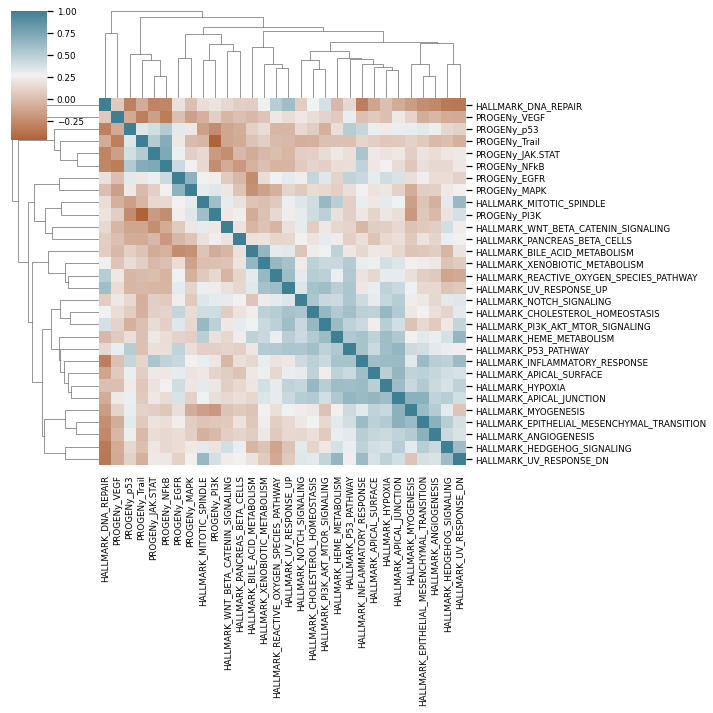

In [33]:
g = sb.clustermap(corr_df, 
                  cmap=sb.diverging_palette(30, 220, n=200))
fig = g.fig